In [1]:
from itertools import product

import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.inference.latent_distribution_test import _median_sign_flips, _fit_plug_in_variance_estimator
from graspy.inference import LatentDistributionTest
from graspy.simulations import rdpg

from hyppo.ksample import KSample
from hyppo._utils import gaussian

from joblib import Parallel, delayed

from scipy.stats import multivariate_normal
from tqdm import tqdm

import sys
sys.path.append("./")
from seedless_procrustes import *
from utils import load_data

%matplotlib inline

print(graspy.__version__)

0.3.0


<AxesSubplot:title={'center':'Right'}>

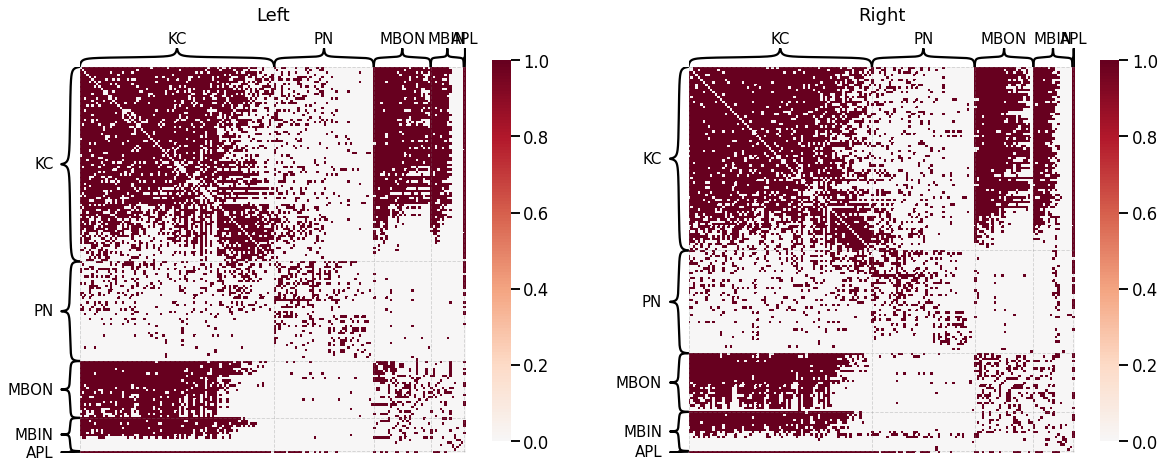

In [2]:
A_l, nodes_l, A_r, nodes_r, hemispheres = load_data()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
graspy.plot.heatmap(A_l, inner_hier_labels=nodes_l, hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r, inner_hier_labels=nodes_r, hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [32]:
def hypothesis_test(X1, X2, flip):
    tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
    
    if flip == 'median':
        X1_flipped, X2_flipped = _median_sign_flips(X1, X2)
        
    elif flip == 'seedless':
        Q = SeedlessProcrustes().fit_predict(X1, X2)
        X1_flipped = X1 @ Q
        X2_flipped = X2
        
    
    pvals = []
    for test in tests:
        res = test.test(X1_flipped, X2_flipped, auto=False)
        pvals.append(res[1])
        
    return pvals

def embed_graphs(A1, A2):
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True, check_lcc=False)
    X1_hat = ase.fit_transform(A1)
    X2_hat = ase.fit_transform(A2)
    
    return X1_hat, X2_hat

def run_non_replacement(X1_hat, X2_hat, n_verts_to_perterb, delta, n_sims=96):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(N), size=n_verts_to_perterb, replace=False)
        
        for idx in range(N):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat[idx] + shift
            else:
                mean = X1_hat[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat[idx], 
                    X2_cov[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(M)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [n_verts_to_perterb, delta, *power]

def run_replacement(X1_hat, X2_hat, X1_verts, X2_verts, n_verts_to_perterb, delta, n_sims=96):
    """
    delta is non-negative number
    """
    d = X1_hat.shape[1]
    N = X1_hat.shape[0]
    M = X2_hat.shape[0]
    
    X1_cov = _fit_plug_in_variance_estimator(X1_hat)(X1_hat) / N
    X2_cov = _fit_plug_in_variance_estimator(X2_hat)(X2_hat) / M
    
    def worker():    
        # Sample new latents
        X1_new = []
        verts_to_perterb = np.random.choice(range(X1_verts), size=n_verts_to_perterb, replace=False)
        
        X1_idx = np.random.choice(range(N), size=X1_verts, replace=True)
        X2_idx = np.random.choice(range(M), size=X2_verts, replace=True)
        
        X1_hat_replaced = X1_hat[X1_idx]
        X2_hat_replaced = X2_hat[X2_idx]
        
        X1_cov_replaced = X1_cov[X1_idx]
        X2_cov_replaced = X2_cov[X2_idx]
        
        for idx in range(X1_verts):
            if idx in verts_to_perterb:
                direction = multivariate_normal.rvs(cov=np.eye(d), random_state=np.random.randint(2147483647))
                direction /= np.linalg.norm(direction)
                shift = direction * delta
                
                mean = X1_hat_replaced[idx] + shift
            else:
                mean = X1_hat_replaced[idx]

            X1_new.append(
                multivariate_normal.rvs(
                    mean,
                    X1_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                )
            )
        X1_new = np.array(X1_new)
        X2_new = np.array(
            [
                multivariate_normal.rvs(
                    X2_hat_replaced[idx], 
                    X2_cov_replaced[idx], 
                    random_state=np.random.randint(2147483647)
                ) for idx in range(X2_verts)
            ]
        )
        
        # Sample new graphs
        A1 = rdpg(X1_new, rescale=False)
        A2 = rdpg(X2_new, rescale=False)
        X1_resampled, X2_resampled = embed_graphs(A1, A2)
        
        # Compute pvals
        pvals_median = hypothesis_test(X1_resampled, X2_resampled, "median")
        pvals_seedless = hypothesis_test(X1_resampled, X2_resampled, "seedless")
        
        return np.hstack([pvals_median, pvals_seedless])
    
    res = Parallel(-1, verbose=0)(delayed(worker)() for _ in range(n_sims))
    
    res = np.array(res)
    power = (res <= 0.05).mean(axis=0)
    
    return [X1_verts, X2_verts, n_verts_to_perterb, delta, *power]

In [4]:
X1_hat, X2_hat = embed_graphs(A_l, A_r)

print(X1_hat.shape[-1])

3


In [9]:
n_verts_to_perterbs = np.linspace(0, 100, 6, dtype=int)
deltas = np.linspace(0, 1, 6)

args = [
    dict(n_verts_to_perterb=n_verts_to_perterb, delta=delta) 
    for n_verts_to_perterb, delta 
    in product(n_verts_to_perterbs, deltas)
]

In [12]:
res = []

for arg in tqdm(args):
    tmp = run_non_replacement(X1_hat, X2_hat, **arg)
    res.append(tmp)

100%|██████████| 36/36 [4:57:58<00:00, 496.64s/it]  


In [17]:
cols = ["n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]

df = pd.DataFrame(res, columns=cols)

df.to_csv("./no_component_replacement.csv", index=False)

In [33]:
res = []

for arg in tqdm(args):
    tmp = run_replacement(X1_hat, X2_hat, X1_verts=150, X2_verts=150, **arg)
    res.append(tmp)

100%|██████████| 36/36 [3:58:09<00:00, 396.92s/it]  


In [35]:
cols = ["x1_verts", "x2_verts", "n_verts_perterbed", "delta", "dcorr_median", "mgc_median", "hsic_median", "dcorr_seedless", "mgc_seedless", "hsic_seedless"]
df2 = pd.DataFrame(res, columns=cols)
df2.to_csv("./component_replacement.csv", index=False)

<AxesSubplot:>

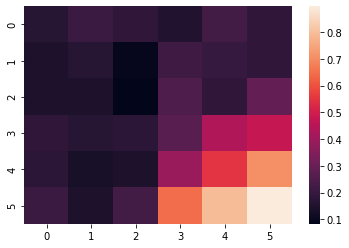

In [38]:
sns.heatmap(df2.mgc_seedless.values.reshape(6, 6))

In [45]:
df

,n_verts_perterbed,delta,dcorr_median,mgc_median,hsic_median,dcorr_seedless,mgc_seedless,hsic_seedless
0,0,0.0,0.635417,0.812500,0.239583,0.0,0.000000,0.0
1,0,0.2,0.552083,0.781250,0.333333,0.0,0.000000,0.0
2,0,0.4,0.687500,0.854167,0.302083,0.0,0.000000,0.0
3,0,0.6,0.635417,0.812500,0.343750,0.0,0.000000,0.0
4,0,0.8,0.656250,0.812500,0.343750,0.0,0.000000,0.0
5,0,1.0,0.708333,0.802083,0.385417,0.0,0.000000,0.0
6,20,0.0,0.687500,0.843750,0.343750,0.0,0.000000,0.0
7,20,0.2,0.572917,0.864583,0.281250,0.0,0.000000,0.0
8,20,0.4,0.531250,0.750000,0.395833,0.0,0.000000,0.0
9,20,0.6,0.479167,0.708333,0.302083,0.0,0.000000,0.0


In [120]:
def plot_heatmaps(df, title=None):
    sns.set_context('talk')
    rows = [["dcorr_median", "mgc_median", "hsic_median"], ["dcorr_seedless", "mgc_seedless", "hsic_seedless"]]
    
    col_names = ["DCorr", "MGC", "HSIC"]
    row_names = ["Median Flip", "Seedless Procrustes"]

    fig, ax = plt.subplots(
        ncols=4, 
        nrows=2, 
        figsize=(16, 10), 
        sharey=True,
        sharex=True,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        constrained_layout=True
    )
    
    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    
    for idx, row in enumerate(rows):
        for jdx, col in enumerate(row):
            data = df[col].values
            size = int(np.sqrt(data.size))
    
            sns.heatmap(
                np.flipud(data.reshape(size, -1)),
                square=True,
                vmin=0,
                vmax=1,
                cmap='RdBu_r',
                center=0,
                ax=ax[idx,jdx],
                cbar_ax=ax_leg,
                yticklabels=np.unique(df.n_verts_perterbed)[::-1],
                xticklabels=[f"{l:0.1f}" for l in np.unique(df.delta)]
            )
        
            if idx == 0:
                ax[idx, jdx].set_title(col_names[jdx])

            if jdx == 0:
                ax[idx, jdx].set_ylabel("# Vertices Perturbed")
            
            if idx == 1:
                ax[idx, jdx].set_xlabel("Delta")
                
    
    if title is not None:
        fig.suptitle(title)
        
    fig.text(-0.015, 0.75, "Median Flip", ha='right', va='center')
    fig.text(-0.015, 0.25, "Seedless Proc.", ha='right', va='center')

    return fig

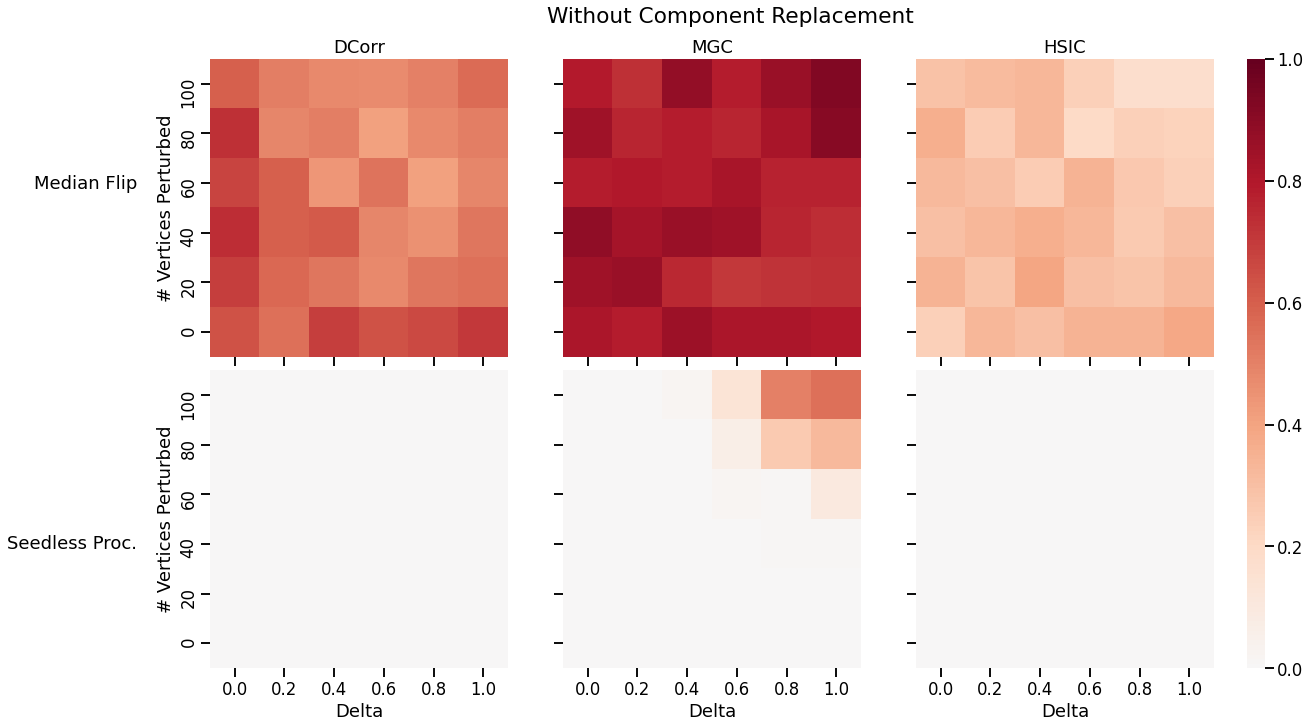

In [122]:
fig = plot_heatmaps(df, title="Without Component Replacement")
fig.savefig("./figures/component_replacement.png", dpi=300, bbox_inches='tight')

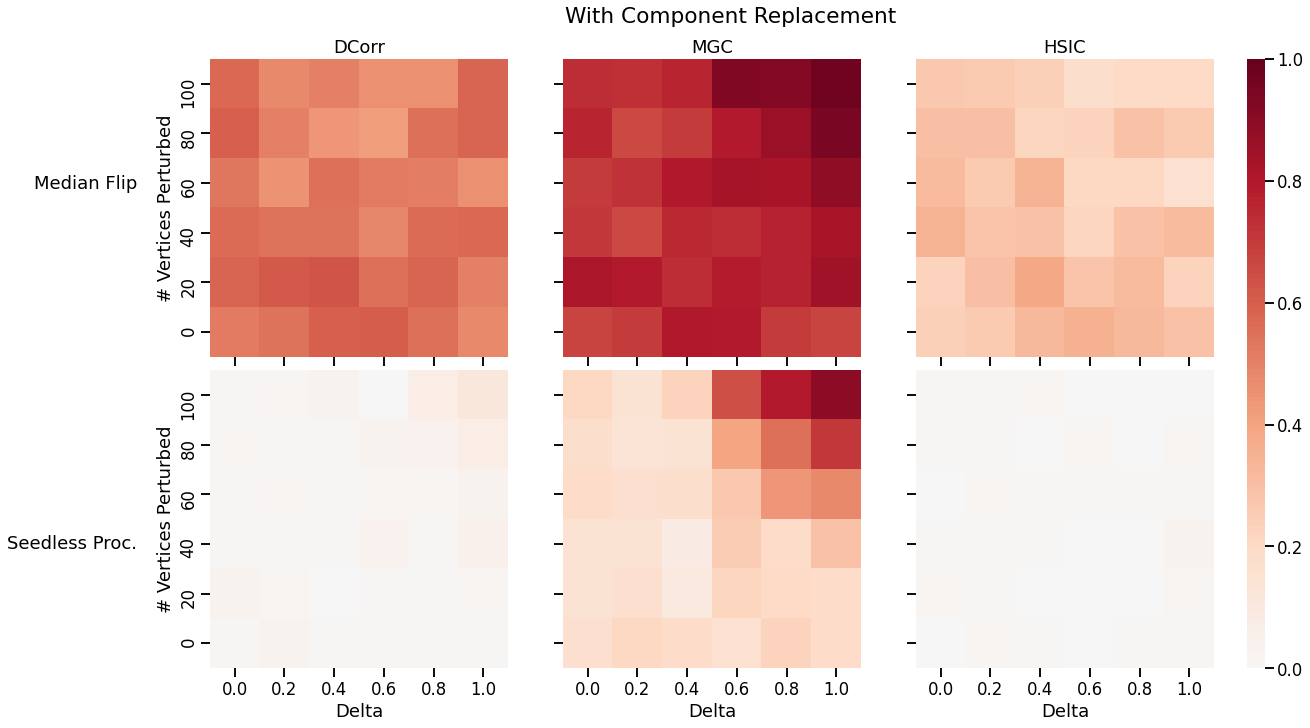

In [123]:
fig = plot_heatmaps(df2, title="With Component Replacement")
fig.savefig("./figures/component_replacement.png", dpi=300, bbox_inches='tight')